**Libraries**

In [6]:
import collections.abc as c

import numpy as np
from scipy.signal import correlate
from scipy.stats import norm
import matplotlib.pyplot as plt

import maskpattern as mp
import plot_module as plot
import balancing as bal
import iros as sk
import stats

**Sky Image Simulation**

In [5]:
def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros(sky_image_shape)

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, sky_image_shape)
        sky_image += sky_background
    else:
        sky_background = None
    
    return sky_image, sky_background, sources_pos

# <center>**Simple Sky Reconstruction and Normalization**<center>

**2D URA Masks**

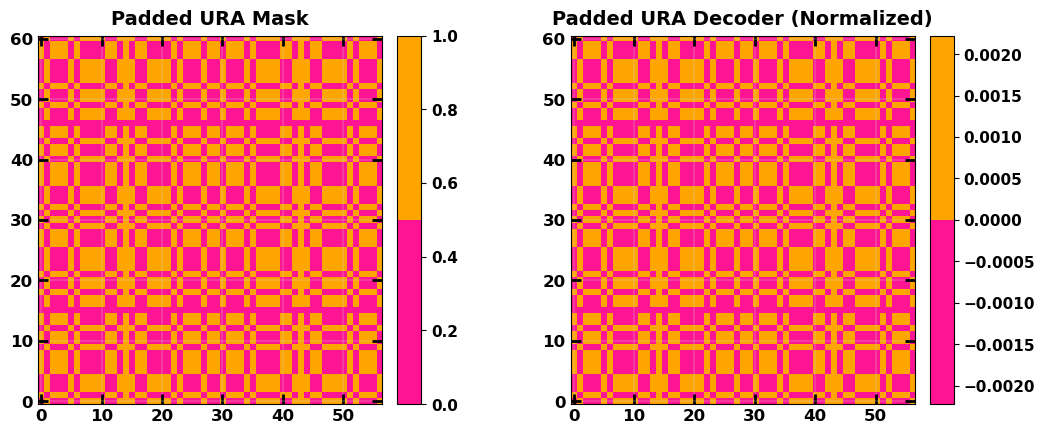

In [4]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["Padded URA Mask", "Padded URA Decoder (Normalized)"])

**Sky Image**

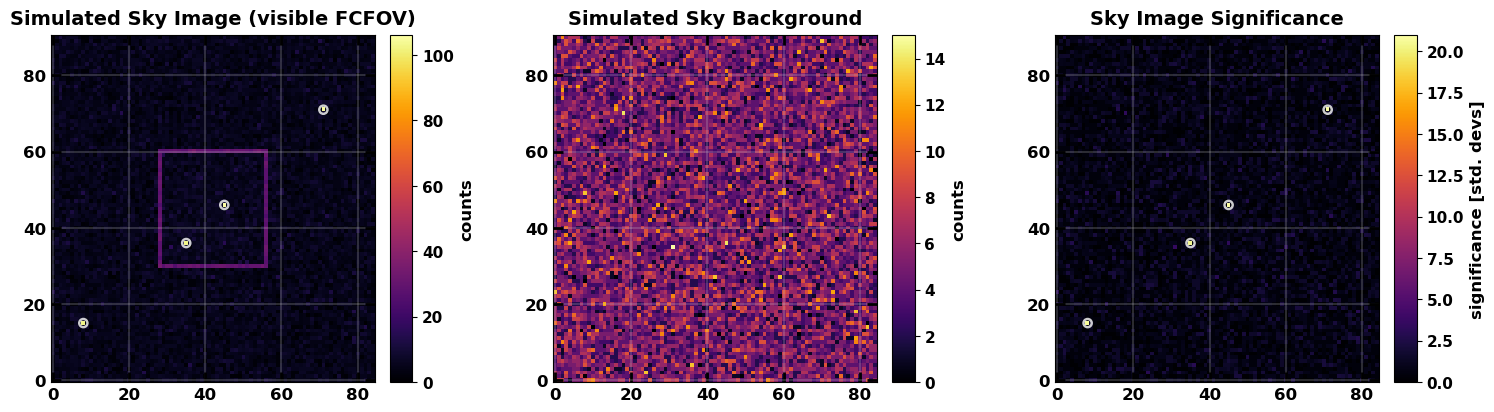

In [43]:
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)
sources_flux = np.array([100]*4)

pcfov_sources = True
if not pcfov_sources:
    sources_pos = [(h + 15, v + 20), (n + 5, m + 6), (n + 15, m + 16), (h + n - 10, v + m - 14)]
else:
    sources_pos = [(h - 15, v - 20), (n + 5, m + 6), (n + 15, m + 16), (h + n + 10, v + m + 14)]

sky_background_rate = 5
sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

if sky_background_rate > 0:
    sky_significance = stats.significance(sky_image, sky_background_rate)
    significance_title = "Sky Image Significance"
else:
    sky_significance = np.zeros(sky_shape)
    significance_title = ""

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background, sky_significance],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background", significance_title],
                    cbarlabel=["counts", "counts", "significance [std. devs]"], 
                    cbarcmap=["inferno"]*3,
                    simulated_sources=[sources_pos, None, sources_pos])

**Detector Image**

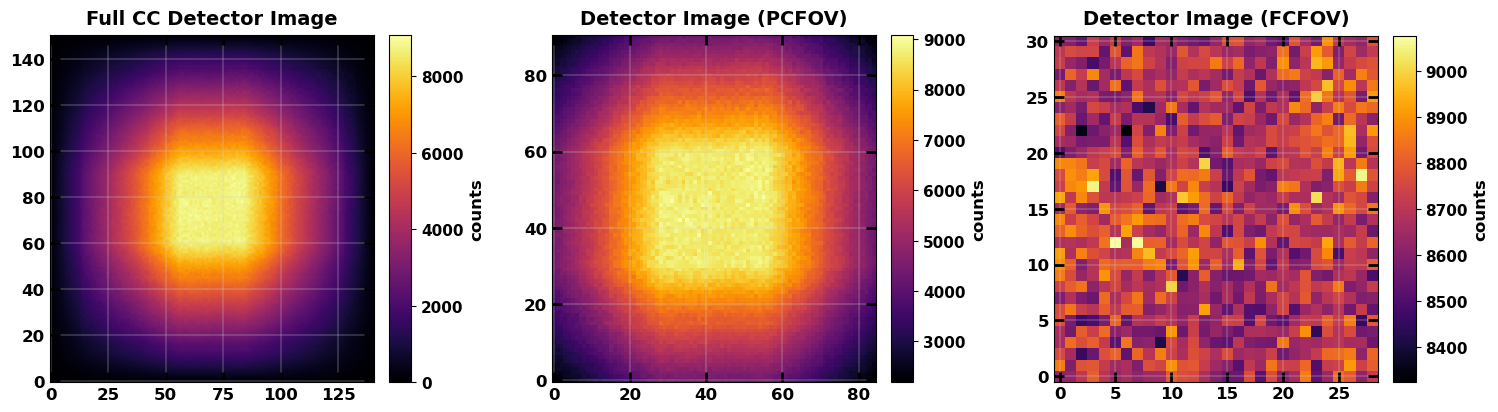

In [44]:
full_detector_image = correlate(mask, sky_image, mode='full')
pcfov_detector_image = full_detector_image[h : -h, v : -v]
fcfov_detector_image = pcfov_detector_image[h : -h, v : -v]

plot.image_plot([full_detector_image, pcfov_detector_image, fcfov_detector_image],
                ["Full CC Detector Image", "Detector Image (PCFOV)", "Detector Image (FCFOV)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3)

In [45]:
full_detector_image.shape == (5*n - 4, 5*m - 4)

True

**Sky Reconstruction**

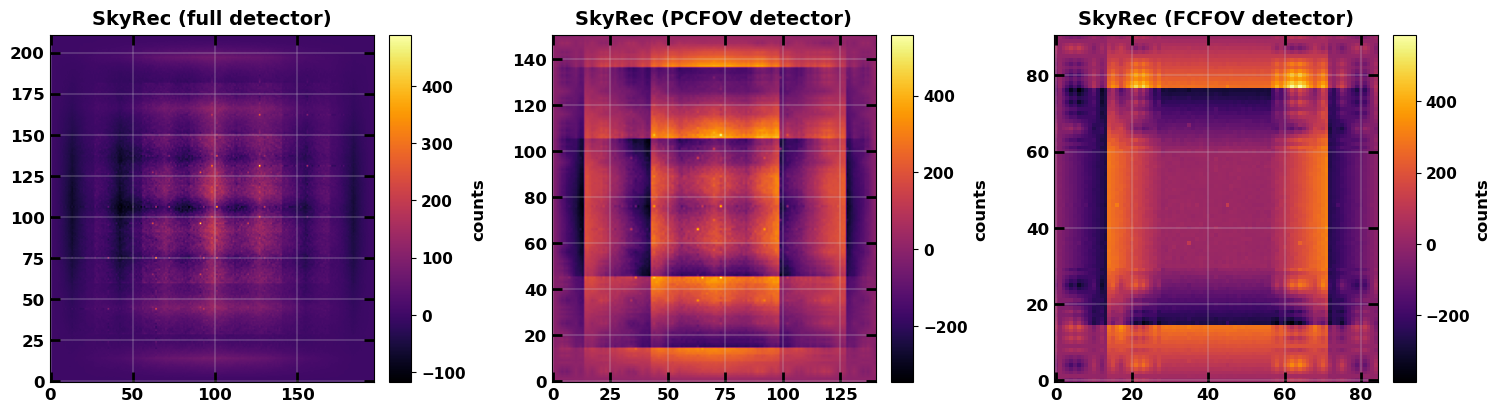

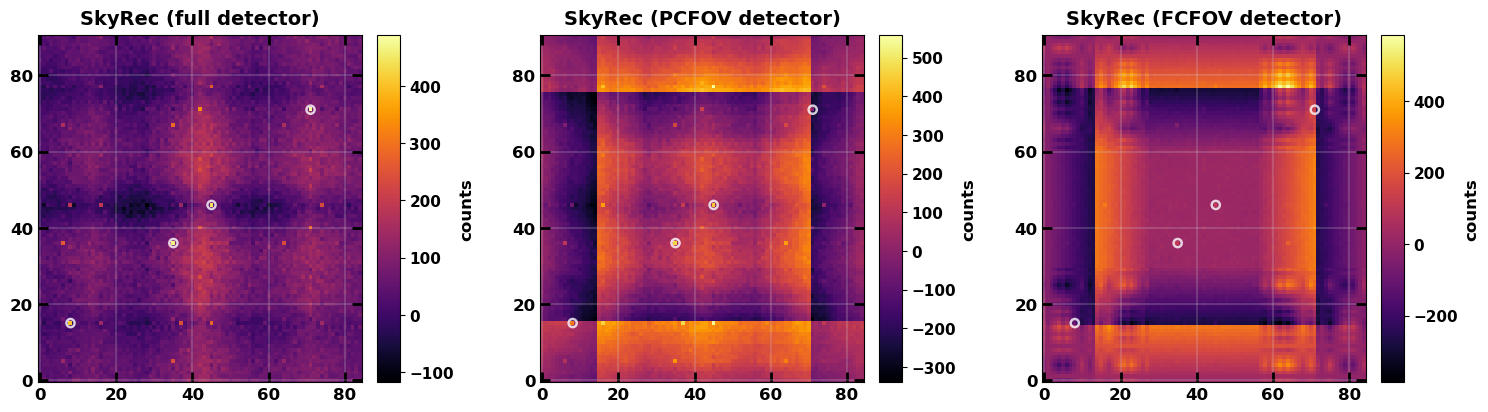

In [46]:
skyrec_with_full_det_img = correlate(decoder, full_detector_image, mode='full')
skyrec_with_pcfov_det_img = correlate(decoder, pcfov_detector_image, mode='full')
skyrec_with_fcfov_det_img = correlate(decoder, fcfov_detector_image, mode='full')

plot.image_plot([skyrec_with_full_det_img, skyrec_with_pcfov_det_img, skyrec_with_fcfov_det_img],
                ["SkyRec (full detector)", "SkyRec (PCFOV detector)", "SkyRec (FCFOV detector)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3)

# if I cut the SkyRec to obtain the same dim as in the true sky image
plot.image_plot([skyrec_with_full_det_img[2*h : -2*h, 2*v : -2*v],
                 skyrec_with_pcfov_det_img[h : -h, v : -v],
                 skyrec_with_fcfov_det_img],
                ["SkyRec (full detector)", "SkyRec (PCFOV detector)", "SkyRec (FCFOV detector)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos]*3)

In [42]:
np.all(skyrec_with_full_det_img[2*h : -2*h, 2*v : -2*v] == correlate(decoder, full_detector_image, mode='valid'))

np.False_

**Notes**

- About the sources, FCFOV, PCFOV and Coding Noise

    1. dimensions (physical and images)
    2. counts
    3. with full decoder, the sources in the PCFOV are correctly reconstructed
    4. sources (only) in the FCFOV and coding noise

- About the Normalization

    1. Normalization in the decoder or in the reconstruction?

# <center>**Sky Reconstruction Balancing**<center>

**Formalism from Peppe**

- The formula from Peppe for balancing the effect of the PCFOV is:

$$\hat{S} = G \star D - G \star W \cdot {\sum d_{i} \over \sum w_{i}}$$

- !!! The simulated sky image has to be corrected with the bulk array, since $W$ gives us the sensitive area of the detector, hence the real observed sky portion

**Formalism from Goldwurm**

- The formula from Goldwurm for balancing the effect of the PCFOV is:

$$\hat{S} = {G^{+} \star (D\cdot W) - B \cdot [G^{-} \star (D\cdot W)] \over N}$$

- where:

    - $W$ is the bulk array or sensitive array, an array of weights for the detector response (values between 0 and 1)
    - $B$ is the balancing array $$B = {G^{+} \star W \over G^{-} \star W}$$
    - $N$ is a normalization array $$N = {(G^{+}\cdot A) \star W - B \cdot [(G^{-}\cdot A) \star W}]$$

<br>

- The balance array $B$ is used to account for the different open to closed mask element ratio and ensures a flat image with zero mean in absence of sources

- The normalization array allows a correct source flux reconstruction which takes into account the partial modulation. With this normalization the sky reconstruction gives at the source peak the mean recorded source counts within one totally illuminated detector pixel.

In [47]:
bulk_array = np.ones(full_detector_image.shape)

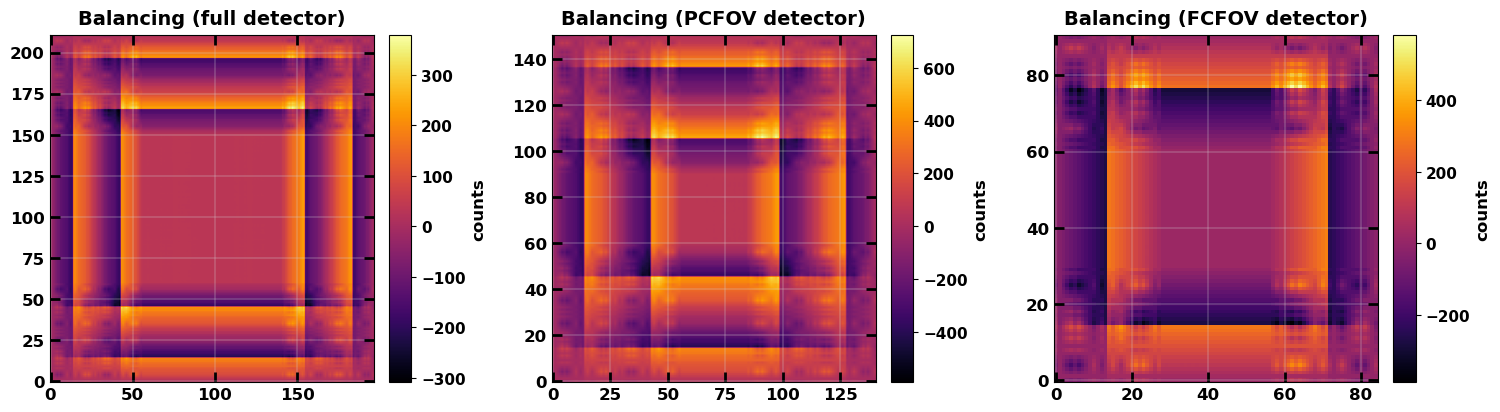

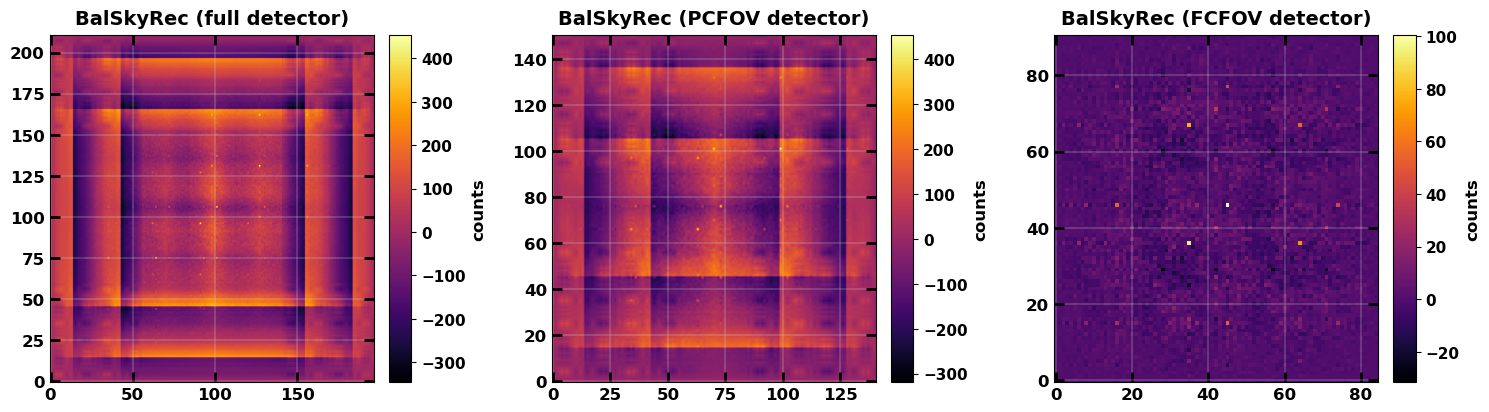

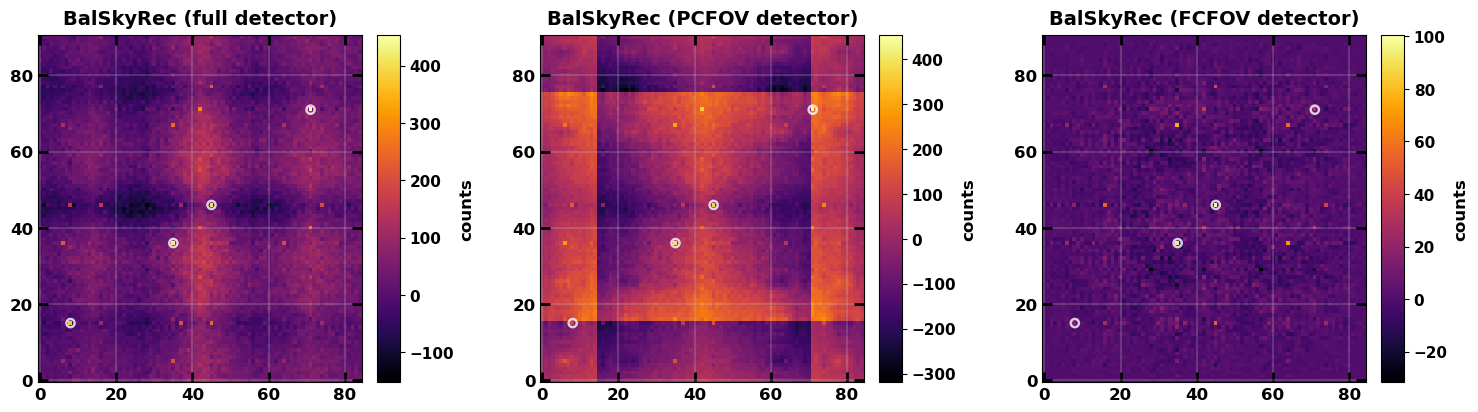

In [52]:
# balancing with Peppe
bal_full = correlate(decoder, bulk_array*(full_detector_image.sum()/bulk_array.sum()))
bal_pcfov = correlate(decoder, bulk_array[h : -h, v : -v]*(pcfov_detector_image.sum()/bulk_array[h : -h, v : -v].sum()))
bal_fcfov = correlate(decoder, bulk_array[2*h : -2*h, 2*v : -2*v]*(fcfov_detector_image.sum()/bulk_array[2*h : -2*h, 2*v : -2*v].sum()))

bal_skyrec_with_full_det_img = skyrec_with_full_det_img - bal_full
bal_skyrec_with_pcfov_det_img = skyrec_with_pcfov_det_img - bal_pcfov
bal_skyrec_with_fcfov_det_img = skyrec_with_fcfov_det_img - bal_fcfov


plot.image_plot([bal_full, bal_pcfov, bal_fcfov],
                ["Balancing (full detector)", "Balancing (PCFOV detector)", "Balancing (FCFOV detector)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3)

plot.image_plot([bal_skyrec_with_full_det_img, bal_skyrec_with_pcfov_det_img, bal_skyrec_with_fcfov_det_img],
                ["BalSkyRec (full detector)", "BalSkyRec (PCFOV detector)", "BalSkyRec (FCFOV detector)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3)

# if I cut the SkyRec to obtain the same dim as in the true sky image
plot.image_plot([bal_skyrec_with_full_det_img[2*h : -2*h, 2*v : -2*v],
                 bal_skyrec_with_pcfov_det_img[h : -h, v : -v],
                 bal_skyrec_with_fcfov_det_img],
                ["BalSkyRec (full detector)", "BalSkyRec (PCFOV detector)", "BalSkyRec (FCFOV detector)"],
                cbarlabel=["counts", "counts", "counts"], 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos]*3)

# <center>**IROS**<center>